Exercises and code samples for the course Unsupervised and Reinforcement Learning (AAI-URL) in the Bachelor of AAI at Rosenheim University of Applied Sciences.


# Lecture 07: Autoencoder

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

## 1) Basic Autoencoder

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist,mnist
from tensorflow.keras.models import Model


/Users/tima268/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Load training dataset (here: either MNIST oder FASHION_MNIST)

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [4]:
x_test.shape

(10000, 28, 28)

Define basic autoencoder (Encoder: 784, Decoder 784)

In [5]:
class Autoencoder(Model):
                  
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation='sigmoid'),  
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Run the Autoencoder with _latent_dimension_ (here: 64):

In [22]:
latent_dim = 32 
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


Train the model(s):

In [23]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0339 - val_loss: 0.0231
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0210 - val_loss: 0.0194
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0182 - val_loss: 0.0174
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 8/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0135 - val_loss: 0.0133
Epoch 9/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 10/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.012

Print the summary:

In [24]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                                                 
Total params: 104608 (408.62 KB)
Trainable params: 104608 (408.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               4224      
                                                          

Output the results:

In [25]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


ValueError: x and y must have same first dimension, but have shapes (64,) and (32,)

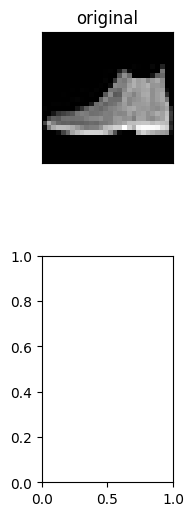

In [26]:
n = 10
plt.figure(figsize=(20, 10))
for i in range(n):
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display encoded
  ax = plt.subplot(3, n, i + 1 + n)
  plt.plot(range(64),encoded_imgs[i])
  plt.title("encoded")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 2 * n + 1)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## 2) De-noising Autoencoder

For denoising we are going to change the training data. We manipulate the data with some noise.

Let's first prepare some data:

In [27]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


This is how the data looks like:

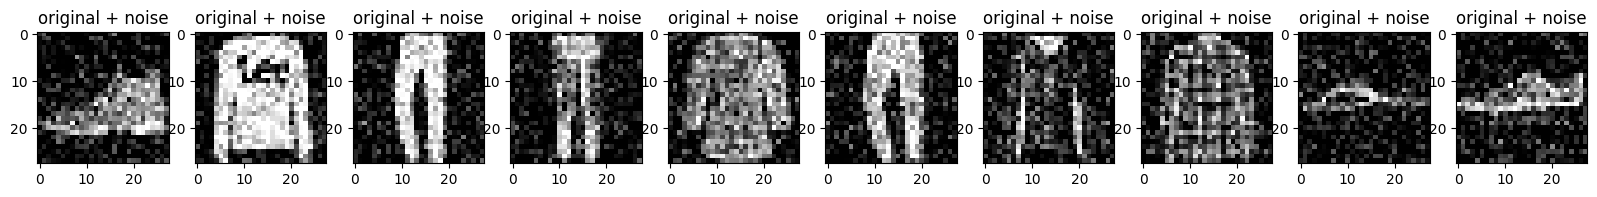

In [28]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()


Now, create a De-noising model:

In [29]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.InputLayer(input_shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




In [30]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [31]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0167 - val_loss: 0.0097
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

In [20]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


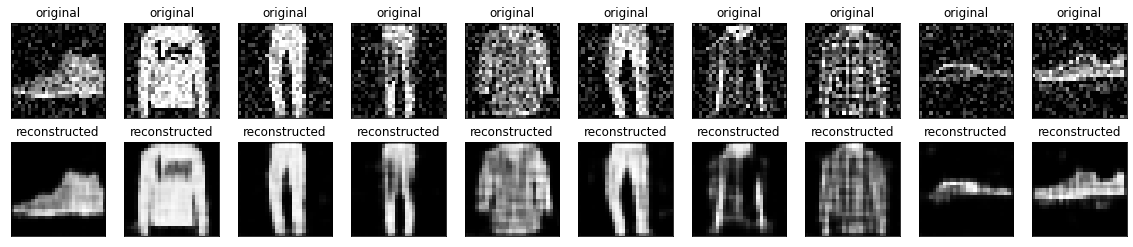

In [21]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

   # display reconstruction
  ax = plt.subplot(2, n, i + n + 1)
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 3) Anomaly detection

Use an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). 

We are trying to identify the abnormal rhythms.

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [35]:
# Download the dataset
dataframe = pd.read_csv('ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()
dataframe.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


In [36]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)


Normalize the data to [0,1].

In [37]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [38]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]


Normal data:

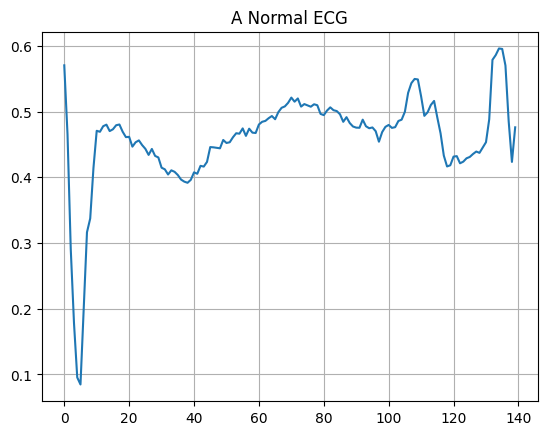

In [39]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()


Unnormal data:

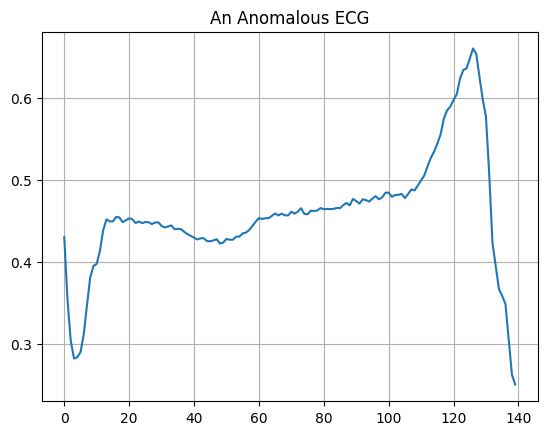

In [40]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()


In [41]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [42]:

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')


Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [43]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)


Epoch 1/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0580 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0512
Epoch 3/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0495
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0494 - val_loss: 0.0477
Epoch 5/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0455 - val_loss: 0.0455
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0416 - val_loss: 0.0438
Epoch 7/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0423
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0345 - val_loss: 0.0407
Epoch 9/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0317 - val_loss: 0.0396
Epoch 10/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0294 - val_loss: 0.0385
Epoch 11/20
5/5 [=====================

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error

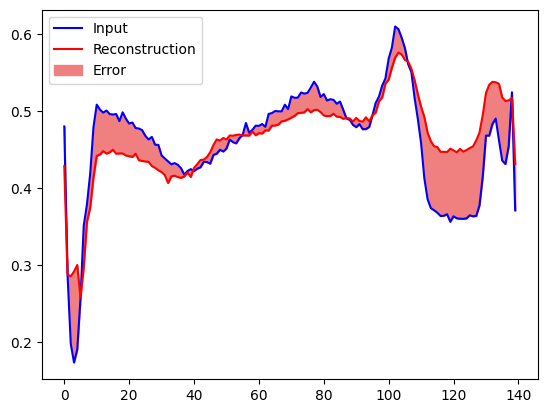

In [44]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Create a similar plot, this time for an anomalous test example.

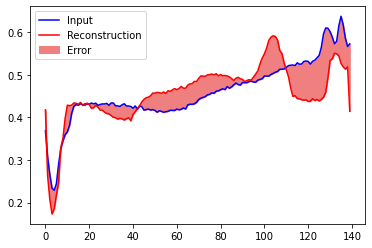

In [32]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set

74/74 [==============================] - 0s 545us/step


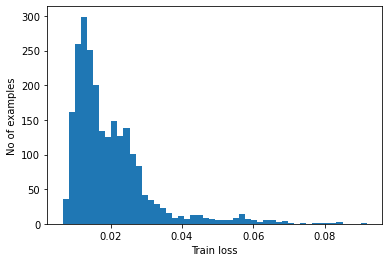

In [33]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


Choose a threshold value that is one standard deviations above the mean.

In [34]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.030855067


If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

14/14 [==============================] - 0s 832us/step


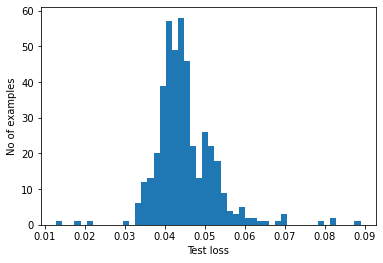

In [35]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()
